In [1]:
#!pip install textblob

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from textblob import TextBlob

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
netflix_data = pd.read_csv('netflix_titles.csv')

In [6]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [7]:
# Top genres based on their count
netflix_data['listed_in'] = netflix_data['listed_in'].str.split(', ')
genres = netflix_data['listed_in'].explode()
top_genres = genres.value_counts().head(5)
print("Top 5 Genres:\n", top_genres)

Top 5 Genres:
 listed_in
International Movies      2752
Dramas                    2427
Comedies                  1674
International TV Shows    1351
Documentaries              869
Name: count, dtype: int64


In [8]:
# Number of movies vs TV shows
content_type_count = netflix_data['type'].value_counts()
print("\nContent Types Count:\n", content_type_count)


Content Types Count:
 type
Movie      6131
TV Show    2676
Name: count, dtype: int64


In [9]:
# Movies with the highest duration
movies = netflix_data[netflix_data['type'] == 'Movie']
movies['duration'] = movies['duration'].str.replace(' min', '').astype(float)
longest_movies = movies.sort_values('duration', ascending=False).head(5)
print("\nTop 5 Longest Movies:\n", longest_movies[['title', 'duration']])


Top 5 Longest Movies:
                             title  duration
4253   Black Mirror: Bandersnatch     312.0
717   Headspace: Unwind Your Mind     273.0
2491       The School of Mischief     253.0
2487               No Longer kids     237.0
2484           Lock Your Girls In     233.0


In [10]:
netflix_data['listed_in'] = netflix_data['listed_in'].apply(lambda x: ' '.join(x.split(',')) if isinstance(x, str) else ' '.join(x))

In [11]:
# Content-Based Recommendation System
tfidf = TfidfVectorizer(stop_words='english')
netflix_data['description'] = netflix_data['description'].fillna('')
tfidf_matrix = tfidf.fit_transform(netflix_data['description'])

In [12]:
# K-Means Clustering for Genres
genres_matrix = tfidf.fit_transform(netflix_data['listed_in'].apply(lambda x: ' '.join(x.split(','))))
kmeans = KMeans(n_clusters=4, random_state=42)
netflix_data['genre_cluster'] = kmeans.fit_predict(genres_matrix)

In [13]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(genres_matrix.toarray())

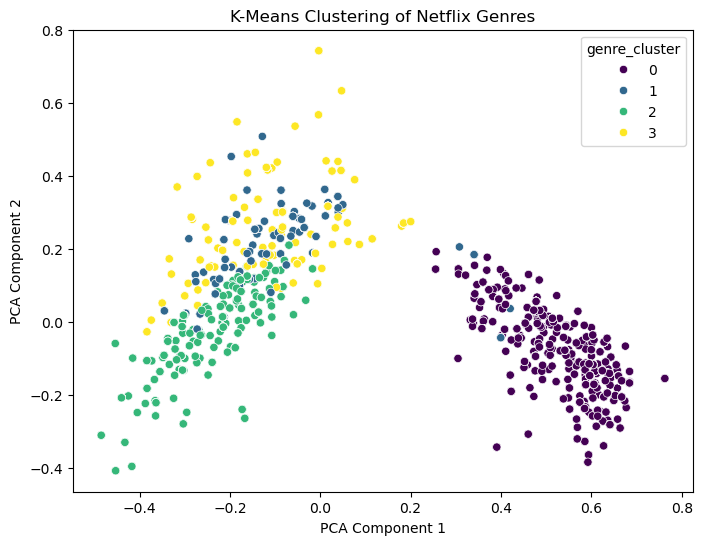

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=netflix_data['genre_cluster'], palette='viridis')
plt.title('K-Means Clustering of Netflix Genres')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [15]:
# Output cluster summary
print("\nCluster Summary by Genre:")
print(netflix_data.groupby('genre_cluster')['title'].count())


Cluster Summary by Genre:
genre_cluster
0    2556
1     874
2    3307
3    2070
Name: title, dtype: int64


In [16]:
netflix_data['type_binary'] = netflix_data['type'].apply(lambda x: 1 if x == 'Movie' else 0)

In [17]:
# For movies
netflix_data['duration'] = netflix_data['duration'].str.replace(' min', '', regex=False)

In [23]:
netflix_data['duration'] = pd.to_numeric(netflix_data['duration'], errors='coerce')  # Coerce non-numeric values to NaN

In [24]:
features = ['release_year', 'duration', 'genre_cluster']

In [31]:
netflix_data['duration'] = netflix_data['duration'].fillna(netflix_data['duration'].mean())

In [32]:
X = netflix_data[features]
y = netflix_data['type_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [35]:
# Predictions
y_pred = model.predict(X_test)

In [39]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [42]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.9824063564131669


In [43]:
print("\nConfusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[ 519   29]
 [   2 1212]]


In [44]:
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       548
           1       0.98      1.00      0.99      1214

    accuracy                           0.98      1762
   macro avg       0.99      0.97      0.98      1762
weighted avg       0.98      0.98      0.98      1762

